In [1]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel, wilcoxon, shapiro
import sys 

from libs_spatial_features_evaluation import *

In [2]:
input_dir1 = "/home/evos/Outputs/SKCM/spatial_features_run1"
input_dir2 = "/home/evos/Outputs/SKCM/spatial_features_run2"
dir_spatial_FF1 = f"{input_dir1}/all_features_combined_FF.csv"
dir_spatial_FF2 = f"{input_dir2}/all_features_combined_FF.csv"
dir_spatial_FFPE_FF1 = f"{input_dir1}/all_features_combined_FFPE_FF.csv"
dir_spatial_FFPE_FF2 = f"{input_dir2}/all_features_combined_FFPE_FF.csv"
dir_spatial_FFPE1 = f"{input_dir1}/all_features_combined_FFPE.csv"
dir_spatial_FFPE2 = f"{input_dir2}/all_features_combined_FFPE.csv"

dir_list = [dir_spatial_FF1, dir_spatial_FF2, dir_spatial_FFPE_FF1, dir_spatial_FFPE_FF2, 
            dir_spatial_FFPE1, dir_spatial_FFPE2]
df_name_list = ["spatial_FF1", "spatial_FF2", "spatial_FFPE_FF1", "spatial_FFPE_FF2",
                "spatial_FFPE1", "spatial_FFPE2"]


In [3]:
cleaned_dfs = {}
for i in range(len(dir_list)):
    directory=dir_list[i]
    df = pd.read_csv(directory, sep="\t")
    
    if 'TCGA_sample_ID' in df.columns:
        df.rename(columns={'TCGA_sample_ID': 'TCGA sample ID'}, inplace=True)
    if 'TCGA_patient_ID' in df.columns:
        df.rename(columns={'TCGA_patient_ID': 'TCGA patient ID'}, inplace=True)
    if 'sample_submitter_id' in df.columns:
        df.rename(columns={'sample_submitter_id': 'sample submitter id'}, inplace=True)
        
    # Now set the standardized column as the index
    df.set_index('TCGA sample ID', inplace=True)
    df_cleaned = clean_graph_feature_df(df)
    cleaned_dfs[df_name_list[i]] = df_cleaned

merged_df_FF = pd.merge(cleaned_dfs["spatial_FF1"], cleaned_dfs["spatial_FF2"], left_index=True, right_index=True, suffixes=(' 1', ' 2'), how='inner')
merged_df_FFPE_FF = pd.merge(cleaned_dfs["spatial_FFPE_FF1"], cleaned_dfs["spatial_FFPE_FF2"], left_index=True, right_index=True, suffixes=(' 1', ' 2'), how='inner')
merged_df_FFPE = pd.merge(cleaned_dfs["spatial_FFPE1"], cleaned_dfs["spatial_FFPE2"], left_index=True, right_index=True, suffixes=(' 1', ' 2'), how='inner')

results_FF = calc_correlations(merged_df_FF, min_pairs=2, corr_method='pearson')
results_FFPE_FF = calc_correlations(merged_df_FFPE_FF, min_pairs=2, corr_method='pearson')
results_FFPE = calc_correlations(merged_df_FFPE, min_pairs=2, corr_method='pearson')
all_results = [results_FF, results_FFPE_FF, results_FFPE]

/home/evos/extra_code/FF_vs_FFPE_analysis/libs_spatial_features_evaluation.py:118: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  clean_merged_df = merged_df.dropna(how='any').applymap(lambda x: x if np.isfinite(x) else np.nan).dropna()


percentage significant correlation: 100.0%


/home/evos/extra_code/FF_vs_FFPE_analysis/libs_spatial_features_evaluation.py:118: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  clean_merged_df = merged_df.dropna(how='any').applymap(lambda x: x if np.isfinite(x) else np.nan).dropna()


percentage significant correlation: 100.0%
percentage significant correlation: 100.0%


/home/evos/extra_code/FF_vs_FFPE_analysis/libs_spatial_features_evaluation.py:118: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  clean_merged_df = merged_df.dropna(how='any').applymap(lambda x: x if np.isfinite(x) else np.nan).dropna()


wilcoxon
1.7854372125059342e-05
wilcoxon
4.4830740098074977e-14
wilcoxon
1.1235957024470704e-11


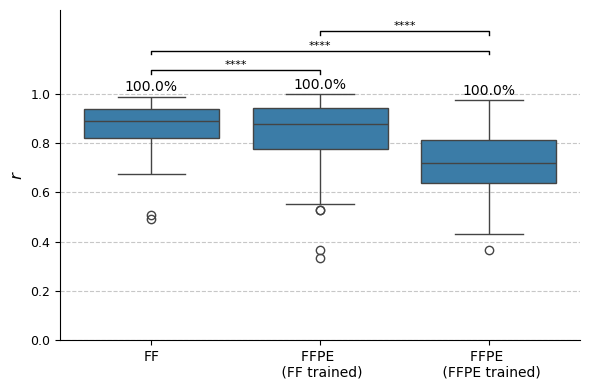

In [4]:
output_dir_plot = "/home/evos/figures/figures_FF_vs_FFPE"
corr_method = 'spearman'
titles_box=['FF', 'FFPE \n (FF trained)', 'FFPE \n (FFPE trained)']

corrs_FF = list(results_FF['corrs'].values())
corrs_FFPE_FF = list(results_FFPE_FF['corrs'].values())
corrs_FFPE = list(results_FFPE['corrs'].values())

plt.figure(figsize=(6, 4))
sns.boxplot(data=[corrs_FF, corrs_FFPE_FF, corrs_FFPE], palette=["#2980b9"] * 3)

# Customize plot
plt.xticks(ticks=range(len(titles_box)), labels=titles_box, rotation=0, fontsize=10)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=9)
plt.ylabel('$r$', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i in range(len(all_results)):
    x_pos = i
    y_pos = max(all_results[i]['corrs'].values())+0.01
    plt.text(x_pos, y_pos, f'{all_results[i]["percentage significant corr"]:.1f}%', ha='center', va='bottom', color='black', fontsize=10)
plt.ylim(0, 1.34) #1.29

# Annotate significance levels above boxplots
y_max = max(max(corrs_FF), max(corrs_FFPE_FF), max(corrs_FFPE))
#y_offsets = [y_max + 0.02, y_max + 0.08, y_max + 0.12] # Increase vertical spacing between accolades
y_offsets = [1.08, 1.16, 1.24]
comparisons = [
    (0, 1, "FF"),
    (0, 2, "FFPE (FF trained)"),
    (1, 2, "FFPE (FFPE trained)")
]

##################3
for idx, (i, j, label) in enumerate(comparisons):
    data1, data2 = [corrs_FF, corrs_FFPE_FF, corrs_FFPE][i], [corrs_FF, corrs_FFPE_FF, corrs_FFPE][j]
    
    # Perform tests
    shapiro_stat1, pvalue1 = shapiro(data1)
    shapiro_stat2, pvalue2 = shapiro(data2)

    if pvalue1 <= 0.05 or pvalue2 <= 0.05:
        print('wilcoxon')
        stat, p_value = wilcoxon(data1, data2)
        print(p_value)
    else:
        print('t-test')
        stat, p_value = ttest_rel(data1, data2)
        #stat, p_value = wilcoxon(data1, data2)
        print(p_value)
    
    # Determine significance stars based on new criteria
    if p_value < 0.0001:
        stars = "****"
    elif p_value < 0.001:
        stars = "***"
    elif p_value < 0.01:
        stars = "**"
    elif p_value < 0.05:
        stars = "*"
    else:
        stars = ""  # No stars if p-value >= 0.05

    # Draw accolades (brackets) and add stars
    if stars:
        x1, x2 = i, j  # Positions of the groups
        y, h = y_offsets[idx], 0.015  # Adjust height for thinner line and more spacing
        plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1, color='black')  # Draw thinner bracket
        plt.text((x1 + x2) / 2, y + h, stars, ha='center', va='bottom', color='black', fontsize=8)  # Adjust stars position
##############

#plt.ylim(-0.3, y_max + 0.12)  # Extend y-axis to fit accolades
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(f"{output_dir_plot}/FF_FFPE_retrain", dpi=300) 
plt.show()
plt.close()  